In [1]:
from nbodykit.lab import *
from fastpm.nbkit import FastPMCatalogSource
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

In [2]:
def fft(inarr):
    finarr= np.fft.fftn(inarr)
    return(finarr)

def ifft(finarr):
    inarr= np.fft.ifftn(finarr)
    return(inarr)

def convolve_NL(L, nc, deltaIC, deltaNL):
    deltaf = fft(deltaIC)
    deltaNLf = fft(deltaNL)

    deltaICNLf = deltaf.copy()

    #kfac = 2.0*np.pi/L

    for i in range(nc):
        for j in range(nc):
            for k in range(nc):
                PL = (deltaf[i,j,k].real**2 + deltaf[i,j,k].imag**2)
                PNL = (deltaNLf[i,j,k].real**2 + deltaNLf[i,j,k].imag**2)
                kernel = np.sqrt(PNL/PL)

                deltaICNLf[i,j,k] = kernel*deltaf[i,j,k]


    deltaICNL = ifft(deltaICNLf)
    deltaICNL = deltaICNL.real
    return deltaICNL

def get_kernel(k, v):
    return v.real**2 + v.imag**2

def NL_field(deltaL, deltaNL):
    Lkernel_field = deltaL.apply(get_kernel, mode='complex', kind='wavenumber')
    NLkernel_field = deltaNL.apply(get_kernel, mode='complex', kind='wavenumber')
    Lkernel = Lkernel_field.compute(mode='complex')
    mask = Lkernel == 0.
    Lkernel[mask] = 1.
    NLkernel = NLkernel_field.compute(mode='complex')
    kernel = np.sqrt(NLkernel/Lkernel)
    return kernel*deltaL.to_field(mode='complex')

def compute_Psi(L, nc, delta):
    '''
    Obtain displacement field under Zeldovich approximation
    '''

    deltaf = fft(delta)

    vfx = deltaf.copy()
    vfy = deltaf.copy()
    vfz = deltaf.copy()

    kfac = 2.0*np.pi/L

    for i in range(nc):
        for j in range(nc):
            for k in range(nc):

                if i <= nc/2:
                    kx = kfac*np.float64(i)
                else:
                    kx = -kfac*np.float64(nc-i)
                if j <= nc/2:
                    ky = kfac*np.float64(j)
                else:
                    ky = -kfac*np.float64(nc-j)
                if k <= nc/2:
                    kz = kfac*np.float64(k)
                else:
                    kz = -kfac*np.float64(nc-k)

                k2 = kx**2 + ky**2 + kz**2

                kernelx = 0.
                kernely = 0.
                kernelz = 0.

                # kernel: -nabla/nabla2 = i*kvec/k2 viene de:
                # d(exp(i*kvec*r))/dr=i*kvec  , d(exp(i*kvec*r))2/dr2=(i*kvec)*(i*kvec)=-k2

                epsk = 1e-14
                if k2>epsk:
                    kernelx = kx/k2
                    kernely = ky/k2
                    kernelz = kz/k2

                vfx.real[i,j,k] = -kernelx*deltaf.imag[i,j,k]
                vfx.imag[i,j,k] =  kernelx*deltaf.real[i,j,k]

                vfy.real[i,j,k] = -kernely*deltaf.imag[i,j,k]
                vfy.imag[i,j,k] =  kernely*deltaf.real[i,j,k]

                vfz.real[i,j,k] = -kernelz*deltaf.imag[i,j,k]
                vfz.imag[i,j,k] =  kernelz*deltaf.real[i,j,k]

    vxg = ifft(vfx)
    vx = vxg.real

    vyg = ifft(vfy)
    vy = vyg.real

    vzg = ifft(vfz)
    vz = vzg.real

    vel1D = np.zeros(nc**3 * 3)
    psi   = vel1D.reshape(nc,nc,nc,3)

    psi[:,:,:,0] = vx
    psi[:,:,:,1] = vy
    psi[:,:,:,2] = vz

    return psi

def forward_evolution(L, nc, vel):

    dL = L/nc

    vx = vel[:,:,:,0]
    vy = vel[:,:,:,1]
    vz = vel[:,:,:,2]

    pos1d = np.zeros(nc**3*3)
    pos = pos1d.reshape(nc,nc,nc,3)
    posic=pos
    posn3 = pos1d.reshape(nc**3, 3)

    for i in range(nc):
          for j in range(nc):
            for k in range(nc):

                rx = 0.5*dL
                ry = 0.5*dL
                rz = 0.5*dL

                xp = float(i)*dL+rx
                yp = float(j)*dL+ry
                zp = float(k)*dL+rz

                posic[i,j,k,0]=xp
                posic[i,j,k,1]=yp
                posic[i,j,k,2]=zp

                xp += vx[i,j,k]
                yp += vy[i,j,k]
                zp += vz[i,j,k]

                if(xp<0):
                    xp += L
                if(xp>=L):
                    xp -= L

                if(yp<0):
                    yp += L
                if(yp>=L):
                    yp -= L

                if(zp<0):
                    zp += L
                if(zp>=L):
                    zp -= L

                pos[i,j,k,0] = xp
                pos[i,j,k,1] = yp
                pos[i,j,k,2] = zp

                l = k + j*(nc + i)
                posn3[l,0] = xp
                posn3[l,1] = yp
                posn3[l,2] = zp

    return posn3

def step_theta(delta, delta_th):
    if delta<delta_th:
        theta = 0
    else:
        theta = 1
    return theta

def obtain_rhog(delta, gamma, alpha, delta_th):
    theta = step_theta(delta, delta_th)
    # print('theta ', theta)
    if theta > 0:
        rhog = theta*gamma*((1.+delta)**alpha)
    else:
        rhog = 0
    return rhog

def make_catalog_g(delta, alpha, gamma, delta_th, Lenght, Nc):
    pos_array = []
    dL = Lenght/Nc

    for ix in range(Nc):
        for iy in range(Nc):
            for iz in range(Nc):
                rhog = obtain_rhog(delta[ix,iy,iz], gamma, alpha, delta_th)
                Ng = int(np.random.poisson(rhog))

                for i in range(Ng):
                    xpos = ix*dL + dL*np.random.uniform()
                    ypos = iy*dL + dL*np.random.uniform()
                    zpos = iz*dL + dL*np.random.uniform()

                    if xpos<0:
                        xpos+=Length
                    if xpos>=Length:
                        xpos-=Length

                    if ypos<0:
                        ypos+=Length
                    if ypos>=Length:
                        ypos-=Length

                    if zpos<0:
                        zpos+=Length
                    if zpos>=Length:
                        zpos-=Length

                    pos_array.append(np.array([xpos, ypos,zpos]))

    return np.array(pos_array)

def field_interpolation(L, nc, psi, pos):

    psi_g = np.zeros_like(pos)

    x = np.linspace(0, L, nc)
    y = np.linspace(0, L, nc)
    z = np.linspace(0, L, nc)

    psix = psi[:,:,:,0]
    psiy = psi[:,:,:,1]
    psiz = psi[:,:,:,2]

    fnx = RegularGridInterpolator((x, y, z), psix, method='linear')
    fny = RegularGridInterpolator((x, y, z), psiy, method='linear')
    fnz = RegularGridInterpolator((x, y, z), psiz, method='linear')

    psi_g[:,0] = fnx(pos)
    psi_g[:,1] = fny(pos)
    psi_g[:,2] = fnz(pos)

    return psi_g

def f(z):
    Omega_mz = cosmology.Planck15.Omega_m(z)
    f = Omega_mz**0.66
    return f

def compute_vr(vel, q, observer, z):
    position_origin = q - observer
    projection_norm = np.linalg.norm(position_origin, axis=1)
    line_of_sight = np.zeros_like(position_origin)
    line_of_sight = position_origin/projection_norm[:, np.newaxis]
    dot_prod = np.sum(vel*line_of_sight, axis=1)
    return f(z)*dot_prod[:, np.newaxis]*line_of_sight

def periodic_conditions(coord, L):
    mask1 = coord<0
    mask2 = coord>=L
    coord[mask1] += L
    coord[mask2] -= L
    return coord

In [3]:
Nc = 256
Length = 1000. # Mpc  h-1
zobs = 0.3

# Setup initial conditions
cosmo = cosmology.Planck15

power = cosmology.LinearPower(cosmo, redshift=zobs)
linear = LinearMesh(power, BoxSize=Length, Nmesh=Nc, seed=21)

In [4]:
linear.save('Lmesh.bigfile')

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [5]:
matter = FastPMCatalogSource(linear, Nsteps=10)
NL_mesh = matter.to_mesh(resampler='cic', interlaced=True, compensated=True)
# NL_mesh.save('NL_mesh')

In [ ]:
# NL_mesh = BigFileMesh('NL_mesh.bigfile', dataset='Field')

deltaICNL = convolve_NL(Length, Nc, (linear.paint(mode='real') - 1.), (NL_mesh.paint(mode='real') - 1.))
Nlinear = ArrayMesh(deltaICNL + 1., Length)

In [6]:
NLfield = NL_field(linear, NL_mesh)
Nlinear = FieldMesh(NLfield)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [7]:
r = FFTPower(linear, mode='1d')
Pklin = r.power['power'].real
k = r.power['k']

r = FFTPower(Nlinear, mode='1d')
Pknlin = r.power['power'].real

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

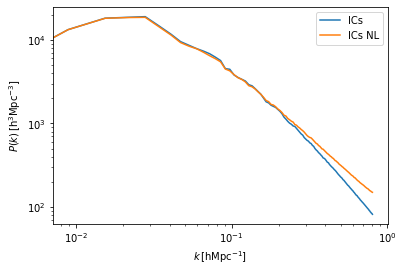

In [8]:
plt.loglog(k, Pklin, label='ICs')
plt.loglog(k, Pknlin, label='ICs NL')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

In [9]:
forward_displf = compute_Psi(Length, Nc, Nlinear.paint(mode='real') - 1.)
forward_displf1 = compute_Psi(Length, Nc, linear.paint(mode='real') - 1.)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [10]:
matter_pos = forward_evolution(Length, Nc, forward_displf)
matter_pos1 = forward_evolution(Length, Nc, forward_displf1)

In [11]:
ww = np.ones(len(matter_pos))
with open('matter_file.dat', 'wb') as ff:
    matter_pos.tofile(ff); ww.tofile(ff); ff.seek(0)

matter_cat = BinaryCatalog(ff.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(matter_pos))
matter_cat.attrs['BoxSize'] = np.array([Length, Length, Length])
matter_cat.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_dm = matter_cat.to_mesh(resampler='cic', interlaced=True, compensated=True)

ww1 = np.ones(len(matter_pos1))
with open('matter_file1.dat', 'wb') as ff1:
    matter_pos1.tofile(ff1); ww1.tofile(ff1); ff1.seek(0)

matter_cat1 = BinaryCatalog(ff1.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(matter_pos1))
matter_cat1.attrs['BoxSize'] = np.array([Length, Length, Length])
matter_cat1.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_dm1 = matter_cat1.to_mesh(resampler='cic', interlaced=True, compensated=True)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/io/binary.py:74: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = numpy.dtype(dtype)


In [12]:
r = FFTPower(delta_dm, mode='1d')
Pkdm = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(delta_dm1, mode='1d')
Pkdm1 = r.power['power'].real - r.attrs['shotnoise']

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

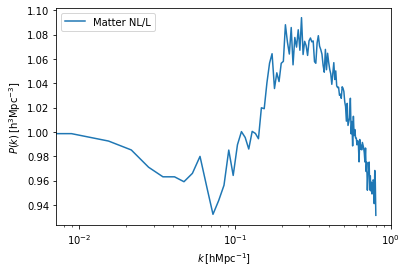

In [13]:
# plt.loglog(k, Pklin, label='ICs L')
# plt.loglog(k, Pknlin, label='ICs NL')
plt.plot(k, Pkdm/Pkdm1, label='Matter NL/L')
# plt.loglog(k, Pkdm1, ':',label='Matter L')
plt.xscale('log')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

In [14]:
alpha = 1.3
delta_th = 0.
gamma = 0.02
# n0 = 3.6e-4
# gamma = n0/np.mean((delta_dm.paint(mode='real'))**alpha)

galaxy_pos = make_catalog_g((delta_dm.paint(mode='real') - 1.), alpha, gamma, delta_th, Length, Nc)
galaxy_pos1 = make_catalog_g((delta_dm1.paint(mode='real') - 1.), alpha, gamma, delta_th, Length, Nc)

In [15]:
Ng = len(galaxy_pos)
n = Ng/Length**3
print('Total of galaxies = ', Ng)
print('Galaxy number density = ', n)
Ng = len(galaxy_pos1)
n = Ng/Length**3
print('Total of galaxies = ', Ng)
print('Galaxy number density = ', n)

Total of galaxies =  439174
Galaxy number density =  0.000439174
Total of galaxies =  430358
Galaxy number density =  0.000430358


In [16]:
ww = np.ones(len(galaxy_pos))
with open('galaxy_file.dat', 'wb') as ff:
    galaxy_pos.tofile(ff); ww.tofile(ff); ff.seek(0)

galaxy_cat = BinaryCatalog(ff.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(galaxy_pos))
galaxy_cat.attrs['BoxSize'] = np.array([Length, Length, Length])
galaxy_cat.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_g = galaxy_cat.to_mesh(resampler='cic', interlaced=True, compensated=True)

ww1 = np.ones(len(galaxy_pos1))
with open('galaxy_file1.dat', 'wb') as ff1:
    galaxy_pos1.tofile(ff1); ww.tofile(ff1); ff1.seek(0)

galaxy_cat1 = BinaryCatalog(ff1.name, [('Position', ('f8', 3)), ('Mass', ('f8', 1))], size=len(galaxy_pos1))
galaxy_cat1.attrs['BoxSize'] = np.array([Length, Length, Length])
galaxy_cat1.attrs['Nmesh'] = np.array([Nc, Nc, Nc])
delta_g1 = galaxy_cat1.to_mesh(resampler='cic', interlaced=True, compensated=True)

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/nbodykit/io/binary.py:74: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype = numpy.dtype(dtype)


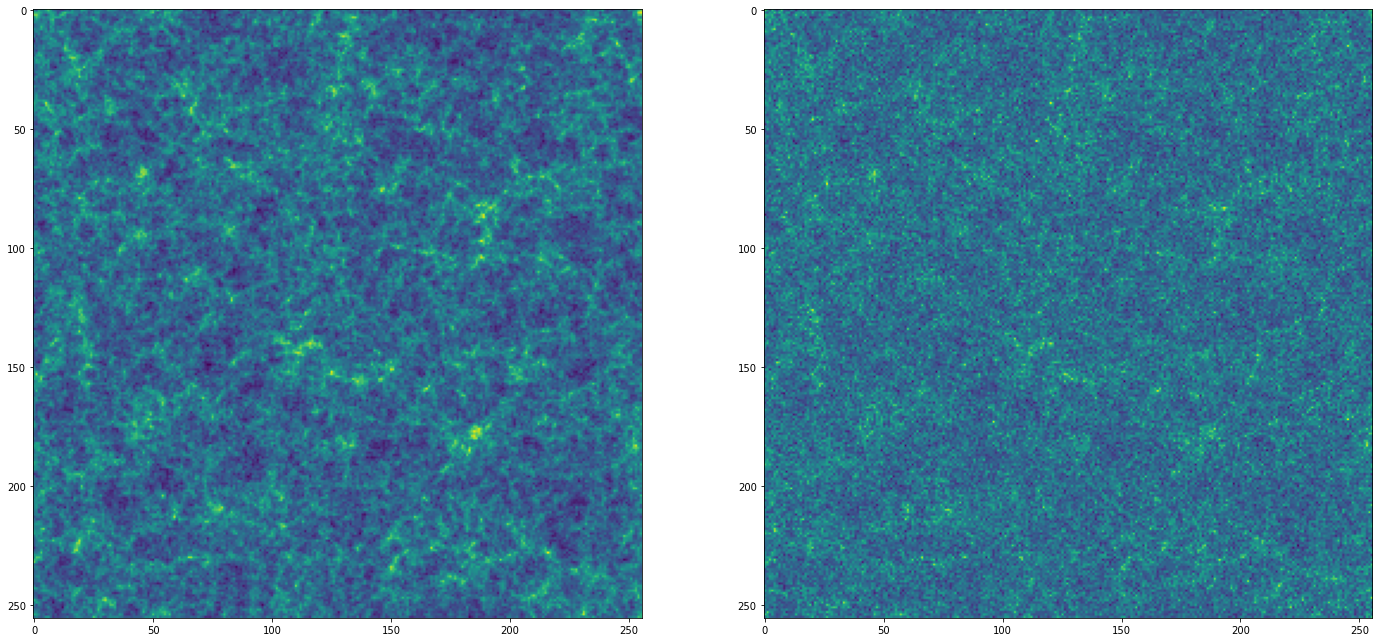

In [18]:
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(delta_dm.paint(mode='real').preview(axes=[1,2]))
ax[1].imshow(delta_g.paint(mode='real').preview(axes=[1,2]))

In [19]:
r = FFTPower(delta_g, mode='1d')
Pkg = r.power['power'].real - r.attrs['shotnoise']
r = FFTPower(delta_g1, mode='1d')
Pkg1 = r.power['power'].real - r.attrs['shotnoise']

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

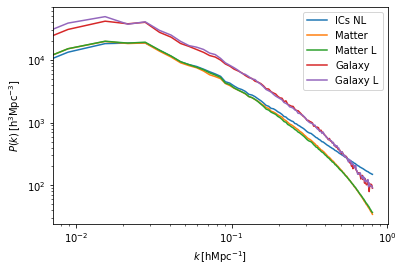

In [20]:
plt.loglog(k, Pknlin, label='ICs NL')
plt.loglog(k, Pkdm, label='Matter')
plt.loglog(k, Pkdm1, label='Matter L')
plt.loglog(k, Pkg, label='Galaxy')
plt.loglog(k, Pkg1, label='Galaxy L')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

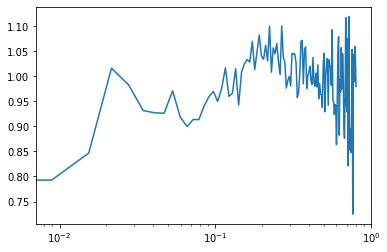

In [21]:
plt.plot(k, Pkg/Pkg1)
plt.xscale('log')

In [22]:
mask = (k>0.03)*(k<=0.09)
bg = np.mean(np.sqrt(Pkg[mask]/Pkdm[mask]))
print('Galaxy bias = {:.2f}'.format(bg))

Galaxy bias = 1.42


Text(0, 0.5, '$\\sqrt{P_g(k)/P_m(k)}$')

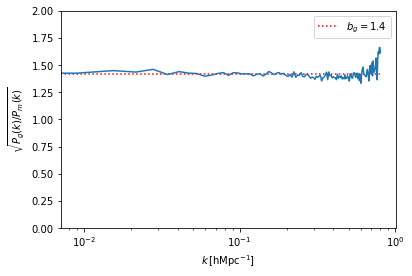

In [23]:
plt.plot(k, np.sqrt(Pkg/Pkdm))
plt.hlines(bg, k.min(), k.max(), linestyles=':', color='r', label=r'$b_g = {:.2}$'.format(bg))
plt.legend()
plt.xscale('log')
plt.ylim(0,2)
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$\sqrt{P_g(k)/P_m(k)}$')

In [24]:
peculiar_field = compute_Psi(Length, Nc, (delta_dm.paint(mode='real') - 1.))

In [25]:
observer = np.array([Length/2,Length/2,Length/2])
vr = compute_vr(field_interpolation(Length, Nc, peculiar_field, galaxy_pos), galaxy_pos, observer, zobs)
# galaxy_posRSD = periodic_conditions(galaxy_pos + vr, Length)
galaxy_cat['PositionRSD'] = galaxy_pos +vr


In [26]:
delta_gRSD = galaxy_cat.to_mesh(position='PositionRSD', resampler='cic', compensated=True, interlaced=True)
r = FFTPower(delta_gRSD, mode='1d')
PkgRSD = r.power['power'].real - r.attrs['shotnoise']

Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

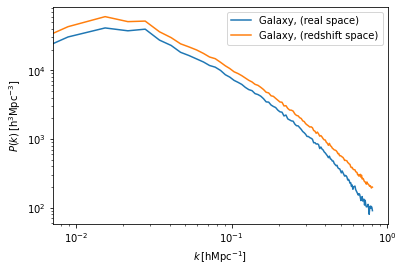

In [27]:
plt.loglog(k, Pkg, label='Galaxy, (real space)')
plt.loglog(k, PkgRSD, label='Galaxy, (redshift space)')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')

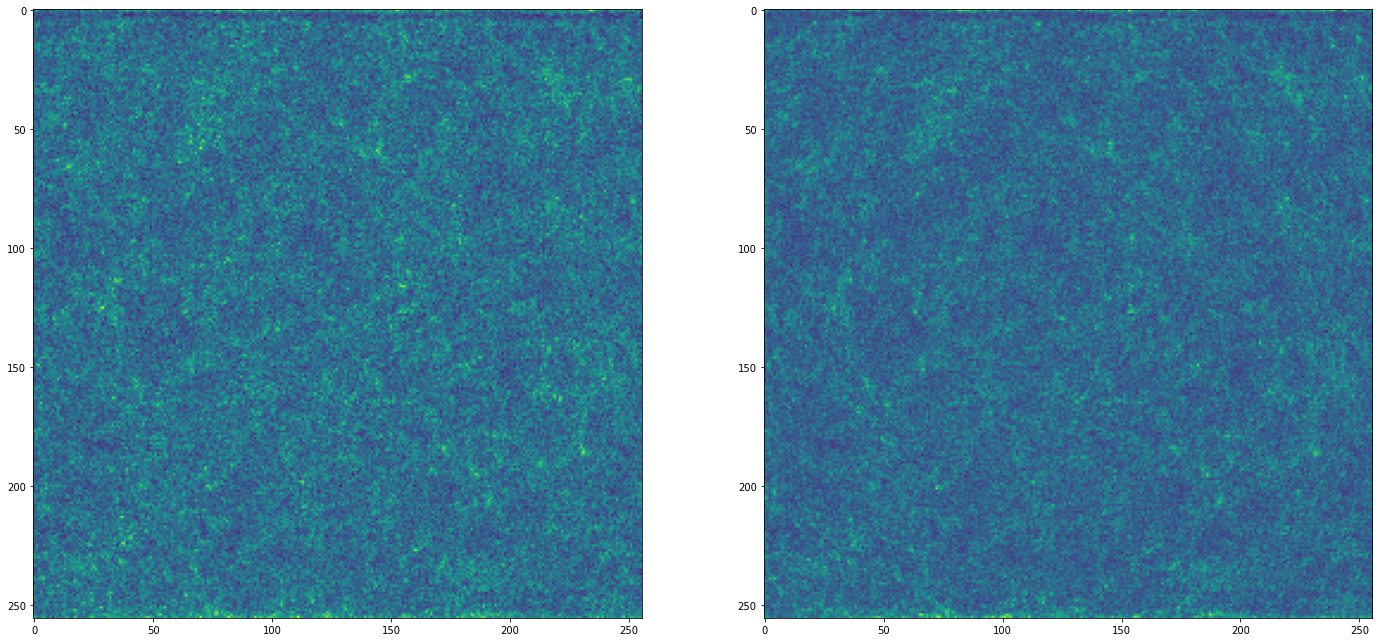

In [28]:
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(delta_g.paint(mode='real').preview(axes=[0,1]))
ax[1].imshow(delta_gRSD.paint(mode='real').preview(axes=[0,1]))

In [29]:
matter_cat.save('Matter_catalog.bigfile')
galaxy_cat.save('Galaxy_catalog.bigfile')